# Decision Tree(의사결정나무)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib as mpl
import graphviz

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz

plt.rcParams['figure.figsize'] = [10, 6]
%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False

pd.set_option('display.max_columns', False)
pd.set_option('display.max_row', False)

## 데이터 불러오기

In [2]:
path = 'data/'

def load_data(name) :
    data = pd.read_csv(path + name + '.csv')
    data = data.drop(columns='Unnamed: 0')
    return data
    
x_train = load_data('x_train')
x_test = load_data('x_test')
y_train = load_data('y_train')
y_test = load_data('y_test')

In [3]:
def con_matrix(model, y_test, y_pred):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    con_mat = confusion_matrix(y_true=y_test, y_pred=y_pred) 
    
    plt.figure(figsize=(6,6))
    sns.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, cmap = 'Blues_r', square = True)
    plt.ylabel('Actual label'); 
    plt.xlabel('Predicted label'); 
    all_sample_title = 'Accuracy Score: {:.4f}'.format(accuracy) 
    plt.title(all_sample_title, size = 14) 
    plt.show()
    
    print('Precision:{:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

### 의사결정나무 모델 구축

In [4]:
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(x_train, y_train) # 학습

DecisionTreeClassifier(random_state=156)

In [5]:
# max_depth = 2
dt_clf = DecisionTreeClassifier(max_depth=2, random_state=156)
dt_clf.fit(x_train, y_train) # 학습

DecisionTreeClassifier(max_depth=2, random_state=156)

### 의사결정나무 모델 가시화

In [6]:
# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성
export_graphviz(dt_clf, out_file="tree.dot", class_names = ["satisfied","neutral or dissatisfied"], feature_names = x_train.columns, impurity=True, filled=True)

[ max_depth의 제약이 없는 경우의 Decision Tree 시각화 ]


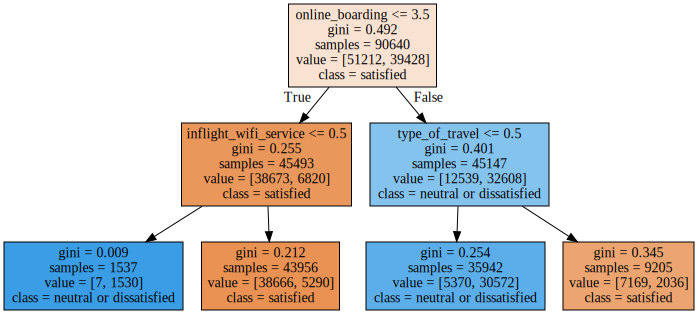

In [7]:
print('[ max_depth의 제약이 없는 경우의 Decision Tree 시각화 ]')

# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

- gini : 다음의 value=[]로 주어진 데이터 분포에서의 지니계수
- samples : 현 규칙에 해당하는 데이터 건수
- value=[] : 클래스 값(y label)에 해당하는 데이터 건수

[ max_depth=2 인 경우의 Decision Tree 시각화 ]


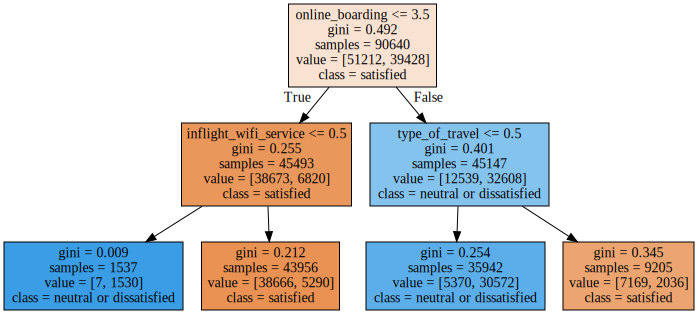

In [8]:
print('[ max_depth=2 인 경우의 Decision Tree 시각화 ]')

# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### 의사결정나무 모델 테스트

In [9]:
y_pred = dt_clf.predict(x_test)

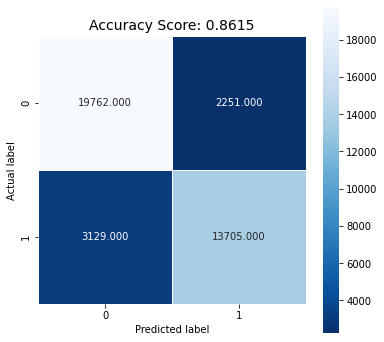

Precision:0.8589
Recall: 0.8141
F1: 0.8359
AUC: 0.8559


In [10]:
con_matrix(x_test, y_test, y_pred)

### Cross Validation

In [11]:
# 교차검증

x = x_train
y = y_train

# 각 폴드의 스코어 
scores = cross_val_score(dt_clf, x, y, cv = 5)

print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.8577118270079435


In [12]:
pd.DataFrame(cross_validate(dt_clf, x, y, cv =5))

,fit_time,score_time,test_score
0,0.118682,0.006982,0.857072
1,0.119679,0.006982,0.857403
2,0.112699,0.005984,0.856410
3,0.104720,0.006982,0.855031
4,0.113696,0.005983,0.862643


In [13]:
# test set에 대한 스코어(정확도)
dt_clf.score(x_test, y_test)

0.8615079671531907

### 하이퍼파라미터 튜닝(그리드 서치)

In [14]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의

dt_clf = DecisionTreeClassifier(random_state=33)
parameters = {'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],      # 트리 모형의 최대 깊이
              'min_samples_split': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],  # 중간노드에서 분리가 일어나기 위한 샘플의 수
              'splitter': ['best', 'random']                              # 노드 분리 방법으로 'random', 'best' 사용
              }

grid_dt = GridSearchCV(dt_clf, param_grid = parameters, cv = 5)

grid_dt.fit(x_train, y_train)

result = pd.DataFrame(grid_dt.cv_results_['params'])
result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,max_depth,min_samples_split,splitter,mean_test_score
155,17,17,random,0.952791
197,21,19,random,0.952747
158,17,21,best,0.952681
179,19,21,random,0.952615
177,19,19,random,0.952615
199,21,21,random,0.952604
153,17,15,random,0.952593
217,23,19,random,0.952593
156,17,19,best,0.952538
112,13,15,best,0.952460


In [15]:
print('최적 하이퍼 파라미터: ', grid_dt.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_dt.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 17, 'min_samples_split': 17, 'splitter': 'random'}
최고 예측 정확도: 0.9528


### 가지치기 수행(Pruning phase)

In [16]:
pruned_dt_clf = DecisionTreeClassifier(max_depth=17, min_samples_split=17, random_state=156) # max_depth=17 으로 제한
pruned_dt_clf .fit(x_train, y_train)

print("훈련 세트 정확도: {:.4f}".format(pruned_dt_clf.score(x_train, y_train)))
print("테스트 세트 정확도: {:.4f}".format(pruned_dt_clf.score(x_test, y_test)))

훈련 세트 정확도: 0.9735
테스트 세트 정확도: 0.9533


가지치기 수행 전보다 test set에 대한 정확도가 향상됨을 확인할 수 있다. (0.9457 -> 0.9533)

In [17]:
# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성
export_graphviz(pruned_dt_clf, out_file="prunedtree.dot", class_names = ["satisfied","neutral or dissatisfied"], feature_names = x_train.columns, impurity=True, filled=True)

In [18]:
print('[ max_depth가 17인 경우의 Decision Tree 시각화 ]')

# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("prunedtree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

[ max_depth가 17인 경우의 Decision Tree 시각화 ]


### 특성 중요도 확인

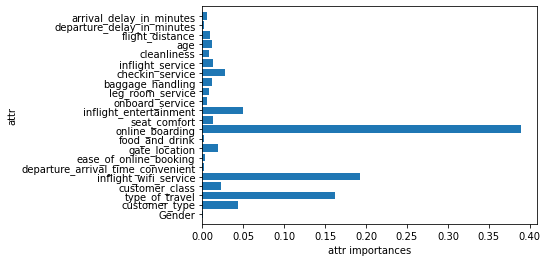

In [19]:
# 특성 중요도 시각화

def plot_feature_importances_airline(model):
    n_features = x_train.columns.shape[0]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), x_train.columns)
    plt.xlabel("attr importances")
    plt.ylabel("attr")
    plt.ylim(-1,n_features)

plot_feature_importances_airline(pruned_dt_clf)
plt.show()

In [20]:
# 특성 중요도
print("특성 중요도 : \n{}".format(pruned_dt_clf.feature_importances_))

특성 중요도 : 
[0.00044251 0.04381874 0.16170099 0.02240681 0.19218125 0.00169321
 0.00264677 0.01895671 0.00159175 0.38971115 0.01235482 0.04992405
 0.00605794 0.00754545 0.01165077 0.02771185 0.01300409 0.00761498
 0.01211367 0.00946339 0.00238183 0.0050273 ]


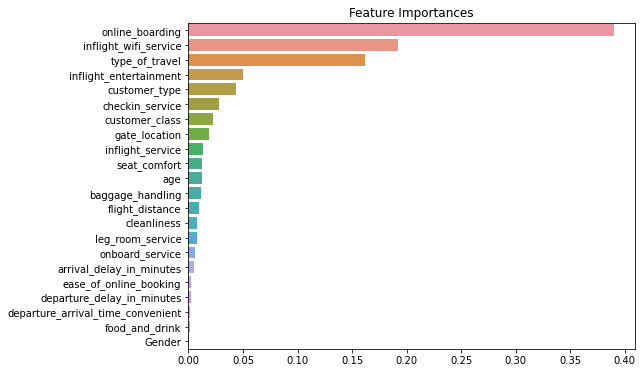

In [21]:
# 특성 중요도 시각화(높은 순)

ftr_importances_values = pruned_dt_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:22]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()